<a href="https://colab.research.google.com/github/hubertrykala93/emotion_classification_predict/blob/main/emotions_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and Setting Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, roc_auc_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

np.set_printoptions(suppress=True, edgeitems=30, linewidth=100000,
                    formatter=dict(float=lambda x: f'{x:.8f}'))
np.random.seed(42)

sns.set()

pd.options.display.float_format = '{:,.8f}'.format
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 100)

In [2]:
path = '/content/tweet emotions.csv'

raw_data = pd.read_csv(filepath_or_buffer=path)
data = raw_data.copy()

Exploring Data

In [3]:
data.head(n=10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [4]:
data.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# Removing unnecessary column
data.drop(columns='emotion_in_tweet_is_directed_at', inplace=True)
data.dropna(inplace=True)

In [7]:
data.columns = ['tweet', 'emotion']

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9092 non-null   object
 1   emotion  9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


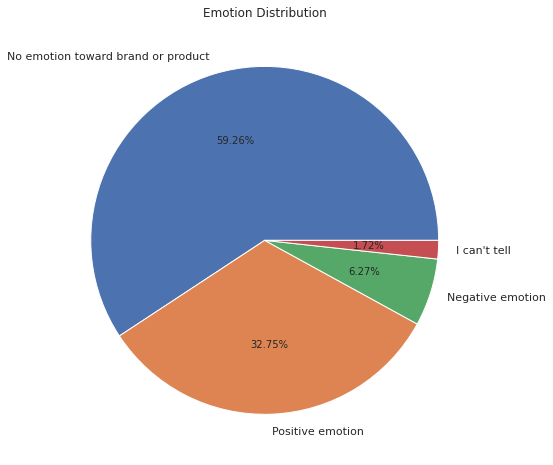

In [9]:
# Emotion Column Distribution Visualization
plt.figure(figsize=(10, 8))
plt.pie(x=data['emotion'].value_counts().values, autopct='%.2f%%', labels=data['emotion'].value_counts().index)
plt.title(label='Emotion Distribution')
plt.show()

Data Preprocessing

In [10]:
# 'No emotion toward brand or product' and 'I can't tell' sounds like that same, so I decided to assign that to 'No emotion'
data['emotion'] = data['emotion'].map(
    arg=lambda x: 'No emotion' if x in ['No emotion toward brand or product', "I can't tell"] else x)

In [11]:
# Cleaning 'tweet' column
def tweet_cleaning(data_frame, column):
    """
    Cleaning 'tweet' column.
    Converting text to lowercases, removing digits, removing unnecessary symbols,
    removing unnecessary words, removing words shorter than 1.
    :return: pandas.DataFrame
    """
    # Text to Lowercase
    data_frame[column] = data_frame[column].map(arg=lambda x: x.lower())

    # Removing Digits
    data_frame[column] = data_frame[column].map(arg=lambda x: ''.join(i for i in x if not i.isdigit()))

    # Removing Unnecessary Symbols
    data_frame[column] = data_frame[column].map(arg=lambda x: ''.join(i for i in x if i not in '!@#$%^&*(){}_?.'))
    data_frame[column] = data_frame[column].map(arg=lambda x: x.replace('/', ' '))

    # Removing Word 'link' and 'sxsw'
    data_frame[column] = data_frame[column].map(arg=lambda x: re.sub('link', '', x))
    data_frame[column] = data_frame[column].map(arg=lambda x: re.sub('sxsw', '', x))

    # Splitting Sentence to List
    data[column] = data[column].map(arg=lambda x: x.split())

    # Removing all Words where Length them is Shorter than 1
    data_frame[column] = data_frame[column].map(arg=lambda x: [i for i in x if len(i) > 1])

    # Joining Words to String
    data_frame[column] = data_frame[column].map(arg=lambda x: ' '.join(x))

    return data_frame

In [12]:
data = tweet_cleaning(data_frame=data, column='tweet')

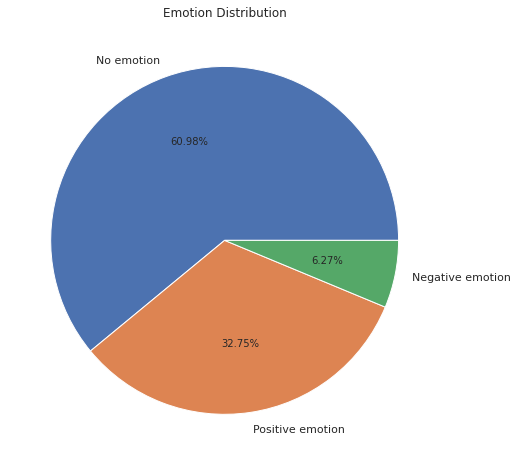

In [13]:
# Emotion Column Distribution Visualization
plt.figure(figsize=(10, 8))
plt.pie(x=data['emotion'].value_counts().values, autopct='%.2f%%', labels=data['emotion'].value_counts().index)
plt.title(label='Emotion Distribution')
plt.show()

Define Data and Target

In [14]:
X = data['tweet']
y = data['emotion']

In [15]:
# Encoding Target
le = LabelEncoder()
le.fit(y=y)
y = le.transform(y=y)

Splitting into Training and Test Set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Define Vectorizer

In [17]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(raw_documents=X_train).toarray()
X_test = vectorizer.transform(raw_documents=X_test).toarray()

MultinomialNB

In [18]:
multinomialNB = MultinomialNB()

In [19]:
multinomialNB.fit(X=X_train, y=y_train)
multinomial_pred = multinomialNB.predict(X=X_test)

In [20]:
multinomialNB_report = classification_report(y_true=y_test, y_pred=multinomial_pred,
                                             zero_division=1, target_names=le.classes_)

In [21]:
print(multinomialNB_report)

                  precision    recall  f1-score   support

Negative emotion       1.00      0.00      0.00       182
      No emotion       0.63      0.97      0.76      1626
Positive emotion       0.75      0.17      0.28       920

        accuracy                           0.64      2728
       macro avg       0.79      0.38      0.35      2728
    weighted avg       0.69      0.64      0.55      2728



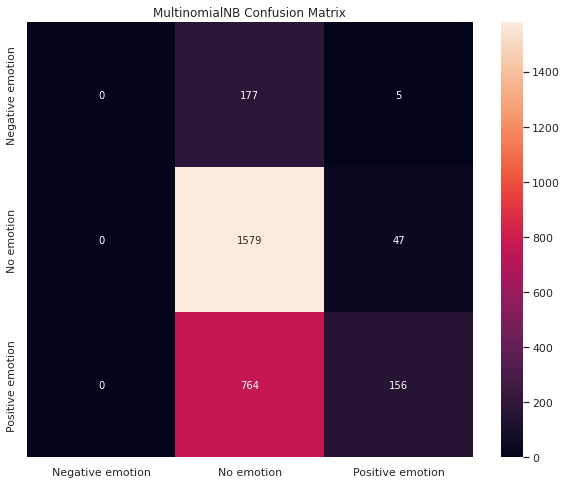

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=confusion_matrix(y_true=y_test, y_pred=multinomial_pred),
            annot=True, fmt='.0f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(label='MultinomialNB Confusion Matrix')
plt.show()

In [23]:
fpr, tpr, threshold = roc_curve(y_true=y_test,
                                y_score=multinomialNB.predict_proba(X=X_test)[:, 1], pos_label=1)

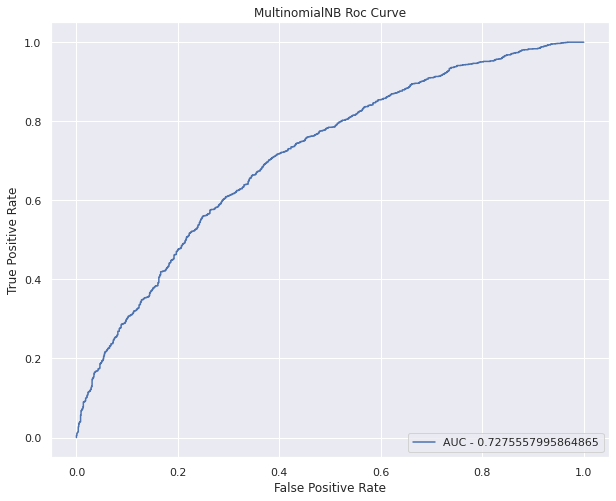

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"AUC - {roc_auc_score(y_true=y_test, y_score=multinomialNB.predict_proba(X=X_test), multi_class='ovr')}")
plt.xlabel(xlabel='False Positive Rate')
plt.ylabel(ylabel='True Positive Rate')
plt.title(label='MultinomialNB Roc Curve')
plt.legend(loc='lower right')
plt.show()

GaussianNB

In [25]:
gaussianNB = GaussianNB()

In [26]:
gaussianNB.fit(X=X_train, y=y_train)
gaussian_pred = gaussianNB.predict(X=X_test)

In [27]:
print(classification_report(y_true=y_test, y_pred=gaussian_pred, target_names=le.classes_))

                  precision    recall  f1-score   support

Negative emotion       0.14      0.33      0.19       182
      No emotion       0.69      0.40      0.51      1626
Positive emotion       0.42      0.62      0.50       920

        accuracy                           0.47      2728
       macro avg       0.42      0.45      0.40      2728
    weighted avg       0.56      0.47      0.49      2728



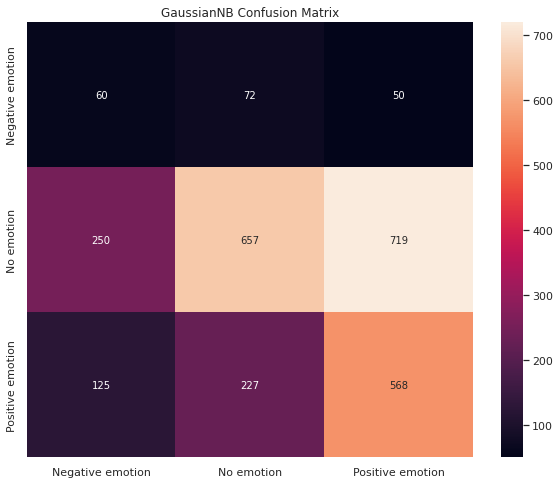

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=confusion_matrix(y_true=y_test, y_pred=gaussian_pred),
            annot=True, fmt='.0f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(label='GaussianNB Confusion Matrix')
plt.show()

In [29]:
fpr, tpr, threshold = roc_curve(y_true=y_test,
                                y_score=gaussianNB.predict_proba(X=X_test)[:, 1], pos_label=1)

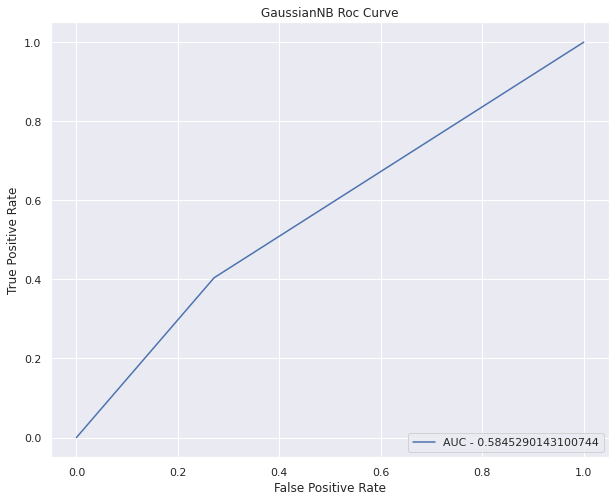

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"AUC - {roc_auc_score(y_true=y_test, y_score=gaussianNB.predict_proba(X=X_test), multi_class='ovr')}")
plt.xlabel(xlabel='False Positive Rate')
plt.ylabel(ylabel='True Positive Rate')
plt.title(label='GaussianNB Roc Curve')
plt.legend(loc='lower right')
plt.show()

Logistic Regression

In [31]:
log = LogisticRegression()

In [32]:
log.fit(X=X_train, y=y_train)
log_pred = log.predict(X=X_test)

In [33]:
print(classification_report(y_true=y_test, y_pred=log_pred, target_names=le.classes_))

                  precision    recall  f1-score   support

Negative emotion       0.63      0.07      0.12       182
      No emotion       0.69      0.88      0.78      1626
Positive emotion       0.65      0.46      0.54       920

        accuracy                           0.68      2728
       macro avg       0.66      0.47      0.48      2728
    weighted avg       0.68      0.68      0.65      2728



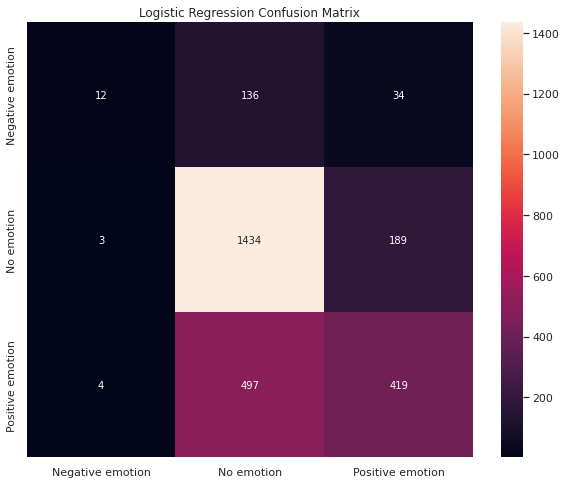

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=confusion_matrix(y_true=y_test, y_pred=log_pred),
            annot=True, fmt='.0f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(label='Logistic Regression Confusion Matrix')
plt.show()

In [35]:
fpr, tpr, threshold = roc_curve(y_true=y_test,
                                y_score=log.predict_proba(X=X_test)[:, 1], pos_label=1)

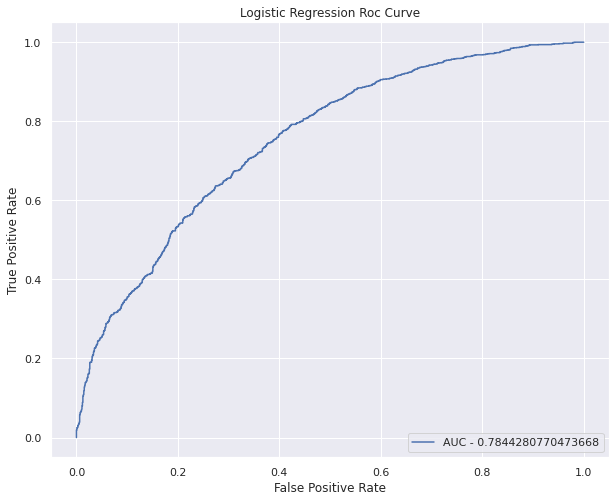

In [36]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"AUC - {roc_auc_score(y_true=y_test, y_score=log.predict_proba(X=X_test), multi_class='ovr')}")
plt.xlabel(xlabel='False Positive Rate')
plt.ylabel(ylabel='True Positive Rate')
plt.title(label='Logistic Regression Roc Curve')
plt.legend(loc='lower right')
plt.show()

Support Vector Classification

In [37]:
svc = SVC(probability=True)

In [38]:
svc.fit(X=X_train, y=y_train)
svc_pred = svc.predict(X=X_test)

In [39]:
print(classification_report(y_true=y_test, y_pred=svc_pred, target_names=le.classes_))

                  precision    recall  f1-score   support

Negative emotion       0.81      0.12      0.20       182
      No emotion       0.68      0.91      0.78      1626
Positive emotion       0.69      0.41      0.52       920

        accuracy                           0.69      2728
       macro avg       0.73      0.48      0.50      2728
    weighted avg       0.69      0.69      0.65      2728



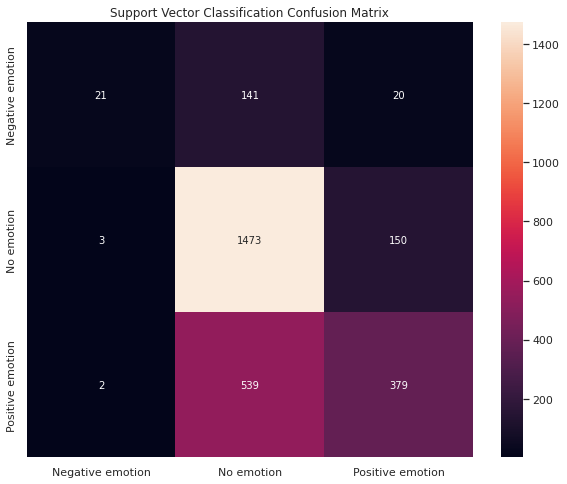

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=confusion_matrix(y_true=y_test, y_pred=svc_pred),
            annot=True, fmt='.0f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(label='Support Vector Classification Confusion Matrix')
plt.show()

In [41]:
fpr, tpr, threshold = roc_curve(y_true=y_test,
                                y_score=svc.predict_proba(X=X_test)[:, 1], pos_label=1)

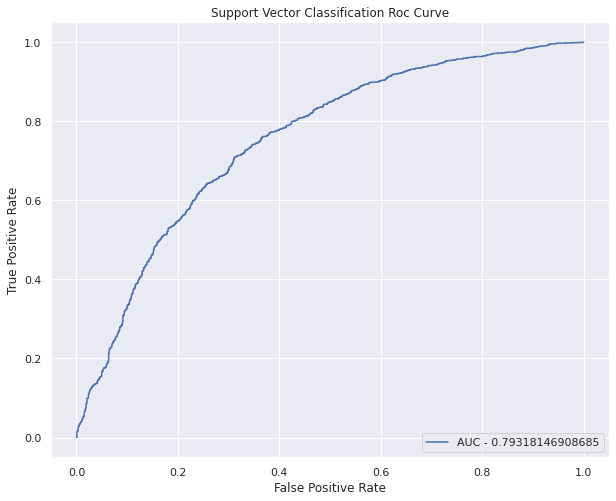

In [42]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"AUC - {roc_auc_score(y_true=y_test, y_score=svc.predict_proba(X=X_test), multi_class='ovr')}")
plt.xlabel(xlabel='False Positive Rate')
plt.ylabel(ylabel='True Positive Rate')
plt.title(label='Support Vector Classification Roc Curve')
plt.legend(loc='lower right')
plt.show()

Creating Scoring DataFrame

In [43]:
names = ['MultinomialNB', 'GaussianNB', 'Logistic Regression', 'SVC']
accuracy_scores = []
aucs = []

accuracy_scores.append(accuracy_score(y_true=y_test, y_pred=multinomial_pred))
accuracy_scores.append(accuracy_score(y_true=y_test, y_pred=gaussian_pred))
accuracy_scores.append(accuracy_score(y_true=y_test, y_pred=log_pred))
accuracy_scores.append(accuracy_score(y_true=y_test, y_pred=svc_pred))
aucs.append(roc_auc_score(y_true=y_test,
                          y_score=multinomialNB.predict_proba(X=X_test), multi_class='ovr'))
aucs.append(roc_auc_score(y_true=y_test,
                          y_score=gaussianNB.predict_proba(X=X_test), multi_class='ovr'))
aucs.append(roc_auc_score(y_true=y_test,
                          y_score=log.predict_proba(X=X_test), multi_class='ovr'))
aucs.append(roc_auc_score(y_true=y_test,
                          y_score=svc.predict_proba(X=X_test), multi_class='ovr'))

scorings = pd.DataFrame(data={
    'names': names,
    'scores': accuracy_scores,
    'auc': aucs
}).sort_values(by='scores')

In [44]:
scorings

,names,scores,auc
1,GaussianNB,0.47104106,0.58452901
0,MultinomialNB,0.63599707,0.72755580
2,Logistic Regression,0.68365103,0.78442808
3,SVC,0.68658358,0.79318147


Save Results to csv

In [45]:
results = pd.DataFrame(data={
    'y_true': y_test,
    'y_pred': svc.predict(X=X_test),
    'flag': y_test == svc.predict(X=X_test)
})

In [46]:
results

,y_true,y_pred,flag
0,1,1,True
1,1,1,True
2,0,1,False
3,2,2,True
4,1,1,True
...,...,...,...
2723,2,2,True
2724,0,1,False
2725,1,1,True
2726,1,1,True


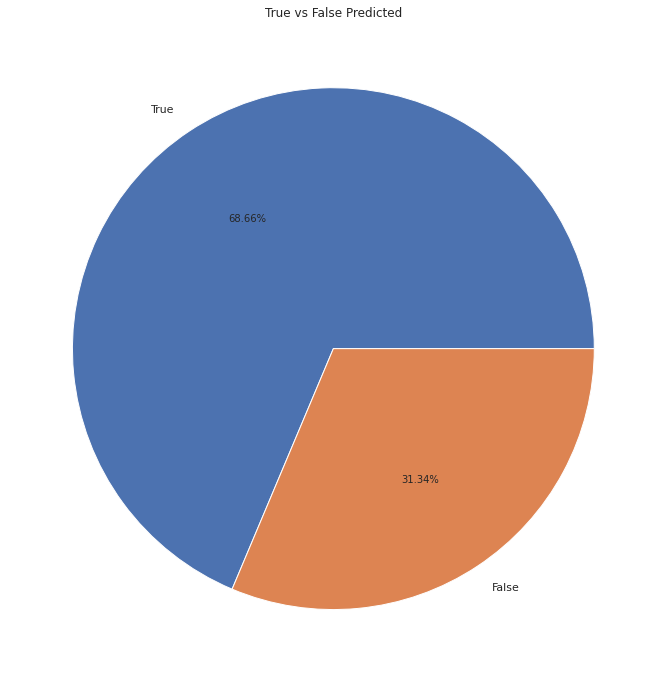

In [47]:
plt.figure(figsize=(12, 12))
plt.pie(x=results['flag'].value_counts().values, labels=results['flag'].value_counts().index, autopct='%.2f%%')
plt.title(label='True vs False Predicted')
plt.show()

In [48]:
results.to_csv(path_or_buf='/content/prediction_results.csv')